# Brain Tumor MRI—Classification

## Import Libraries, Preferences, and Helper Functions

### Libraries

In [ ]:
# System
import os
import warnings

# Google drive
from google.colab import drive

# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Class weight calculation
from sklearn.utils.class_weight import compute_class_weight

# TensorFlow
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.17.1


In [ ]:
# TensorFlow Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, MobileNetV2, DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras import regularizers

### Prefences

In [ ]:
EPOCHS = 2
NUM_GPUS = 2
BATCH_SIZE = 48
IMAGE_HEIGHT, IMAGE_WIDTH = 299, 299

In [ ]:
# Suppress warnings
warnings.filterwarnings('ignore')

# Set the default Seaborn style
sns.set_theme(style='whitegrid', font='serif')

# Create the models directory if it doesn't exist
os.makedirs("models", exist_ok=True)

# Using google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Helper Functions

#### Data Generators

In [ ]:
# Data generator preprocessing and augmentation
datagen_pre_aug = ImageDataGenerator(
  rescale=1./255,
  rotation_range=5,
  width_shift_range=0.05,
  height_shift_range=0.05,
  shear_range=0.05,
  zoom_range=0.05,
  brightness_range=[0.95, 1.05],
  horizontal_flip=False,
  vertical_flip=False,
  fill_mode='nearest',
)

# Data generator preprocessing only
datagen_pre = ImageDataGenerator(
  rescale=1./255
)

### Load and Preprocess

In [ ]:
def load_and_preprocess_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3)
    image = tf.image.resize(image, [IMAGE_HEIGHT, IMAGE_WIDTH])
    image = image / 255.0
    return image, label

## Dataset Path

In [ ]:
def get_dataset_path(use_google_drive=False):
  if use_google_drive:
    TRAINING_DATASET = '/content/drive/My Drive/Datasets/Brain Tumor MRI/raw/training/'
    TESTING_DATASET = '/content/drive/My Drive/Datasets/Brain Tumor MRI/raw/testing/'

  else:
    TRAINING_DATASET = '../datasets/raw/training/'
    TESTING_DATASET = '../datasets/raw/testing/'

  return TRAINING_DATASET, TESTING_DATASET

## Load the Data

In [ ]:
# Get the dataset paths based on whether Google Drive is being used
TRAINING_DATASET, TESTING_DATASET = get_dataset_path(use_google_drive=True)

# Preview dataset path
print(f"Training dataset path: {TRAINING_DATASET}")
print(f"Testing dataset path: {TESTING_DATASET}")

Training dataset path: /content/drive/My Drive/Datasets/Brain Tumor MRI/raw/training/
Testing dataset path: /content/drive/My Drive/Datasets/Brain Tumor MRI/raw/testing/


In [ ]:
train_dataset = datagen_pre_aug.flow_from_directory(
  directory=TRAINING_DATASET,
  color_mode='rgb',
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  shuffle=True,
  seed=42
)

Found 2870 images belonging to 4 classes.


In [ ]:
test_dataset = datagen_pre_aug.flow_from_directory(
  directory=TESTING_DATASET,
  color_mode='rgb',
  target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
  batch_size=BATCH_SIZE,
  class_mode='categorical',
  shuffle=True,
  seed=42
)

Found 394 images belonging to 4 classes.


## Explorative Data Analysis

In [ ]:
class_weights = compute_class_weight(
  class_weight='balanced',
  classes=np.unique(train_dataset.classes),
  y=train_dataset.classes
)

class_weights = dict(enumerate(class_weights))

# Preview the class weights
class_weights

{0: 0.8686440677966102,
 1: 0.8728710462287105,
 2: 1.8164556962025316,
 3: 0.8675937122128174}

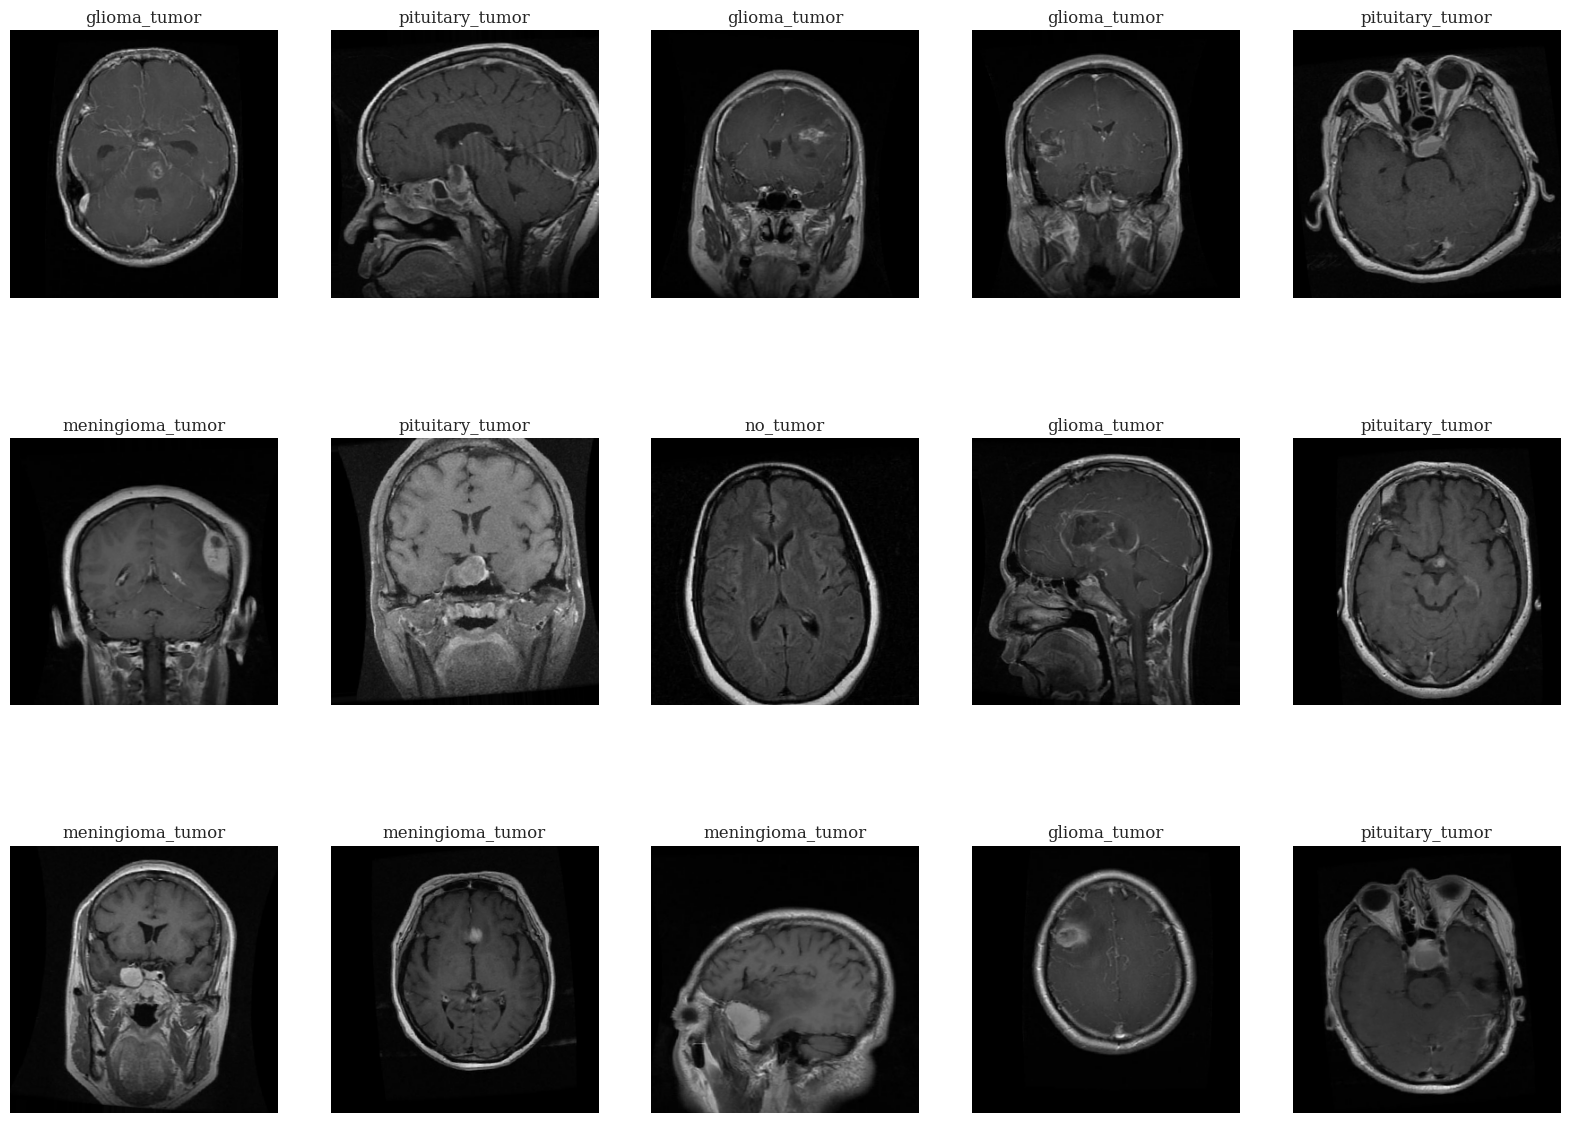

In [ ]:
classes = train_dataset.class_indices
class_names = list(classes.keys())

# Get the next batch of images and labels
img, label = next(train_dataset)

# Set the figure size
plt.figure(figsize=(20, 15))

# Plot sample images
for i in range(15):
  plt.subplot(3, 5, i + 1)
  plt.imshow(img[i])
  plt.axis('off')
  plt.title(class_names[np.argmax(label[i])])

# Display the plot
plt.show()

## Model Building

### Convolutional Neural Networks

In [ ]:
# Early stopping callback
early_stopping = EarlyStopping(
  monitor='val_accuracy',
  patience=2,
  verbose=1,
  restore_best_weights=True
)

### VGG16

In [ ]:
# Initialize Mirrored Strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
    # Load the VGG16 base model
    VGG16_base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
    )

    # Set the layer to non-train
    for layer in VGG16_base_model.layers:
        layer.trainable = False

    # Initialize the model
    VGG16_model = Sequential()
    VGG16_model.add(VGG16_base_model)

    # Add connected layers and output layer
    VGG16_model.add(GlobalAveragePooling2D())
    VGG16_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    VGG16_model.add(Dropout(0.4))
    VGG16_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    VGG16_model.add(Dropout(0.2))
    VGG16_model.add(Dense(4, activation='softmax'))

    # Compile the model
    VGG16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Fit the model
    VGG16_history = VGG16_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=[early_stopping],
    )

    # Save the model
    model_path = os.path.join("models", "vgg16_model.keras")
    VGG16_model.save(model_path)
    print(f"\nModel saved to {model_path}")

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 1574s 24s/step - accuracy: 0.2967 - loss: 1.6465 - val_accuracy: 0.4239 - val_loss: 1.4948
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 105s 2s/step - accuracy: 0.4884 - loss: 1.3121 - val_accuracy: 0.4061 - val_loss: 1.5697
Restoring model weights from the end of the best epoch: 1.

Model saved to models/vgg16_model.keras


In [ ]:
# Preview model summary
VGG16_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 9, 9, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,937,230 (56.98 MB)

 Trainable params: 74,180 (289.77 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 148,362 (579.54 KB)

In [ ]:
# Validation accuracy
VGG16_val_loss, VGG16_val_accuracy = VGG16_model.evaluate(test_dataset, steps=len(test_dataset))
print('[VALIDATION]')
print(f'Accuracy: {VGG16_val_accuracy * 100:.2f}%')
print(f'Loss: {VGG16_val_loss:.2f}\n')

# Training accuracy
VGG16_train_loss, VGG16_train_accuracy = VGG16_model.evaluate(train_dataset, steps=len(train_dataset))
print('[TRAINING]')
print(f'Accuracy: {VGG16_train_accuracy * 100:.2f}%')
print(f'Loss: {VGG16_train_loss:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 0.4171 - loss: 1.4979
[VALIDATION]
Accuracy: 40.46%
Loss: 1.50

60/60 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.6274 - loss: 1.3440
[TRAINING]
Accuracy: 64.28%
Loss: 1.34


#### Visualize the Model

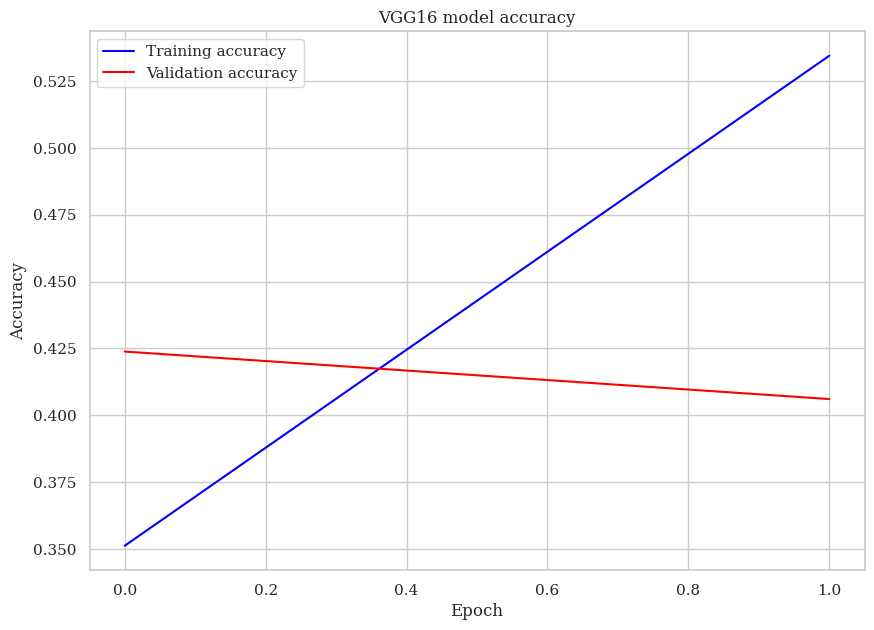

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot training and validation accuracy
plt.plot(VGG16_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(VGG16_history.history['val_accuracy'], label='Validation accuracy', color='red')

# Add title and labels
plt.title('VGG16 model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the legend
plt.legend()

# Display the plot
plt.show()

### MobileNetV2

In [ ]:
# Initialize Mirrored Strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
  # Load the MobileNetV2 base model
  MobileNetV2_base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  )

  # Set the layer to non-train
  for layer in MobileNetV2_base_model.layers:
    layer.trainable = False

  # Initialize the model
  MobileNetV2_model = Sequential()
  MobileNetV2_model.add(MobileNetV2_base_model)

  # Add connected layers and output layer
  MobileNetV2_model.add(GlobalAveragePooling2D())
  MobileNetV2_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  MobileNetV2_model.add(Dropout(0.4))
  MobileNetV2_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  MobileNetV2_model.add(Dropout(0.2))
  MobileNetV2_model.add(Dense(4, activation='softmax'))

  # Compile the model
  MobileNetV2_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit the model
  MobileNetV2_history = MobileNetV2_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=[early_stopping],
  )

  # Save the model
  model_path = os.path.join("models", "mobilenetv2_model.keras")
  MobileNetV2_model.save(model_path)
  print(f"\nModel saved to {model_path}")

Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.4624 - loss: 1.4502 - val_accuracy: 0.5051 - val_loss: 1.7288
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.7496 - loss: 0.8650 - val_accuracy: 0.4924 - val_loss: 1.8988
Restoring model weights from the end of the best epoch: 1.

Model saved to models/mobilenetv2_model.keras


In [ ]:
# Preview model summary
MobileNetV2_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 10, 10, 1280)        │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,775,438 (10.59 MB)

 Trainable params: 172,484 (673.77 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 344,970 (1.32 MB)

In [ ]:
# Validation accuracy
MobileNetV2_val_loss, MobileNetV2_val_accuracy = MobileNetV2_model.evaluate(test_dataset, steps=len(test_dataset))
print('[VALIDATION]')
print(f'Accuracy: {MobileNetV2_val_accuracy * 100:.2f}%')
print(f'Loss: {MobileNetV2_val_loss:.2f}\n')

# Training accuracy
MobileNetV2_train_loss, MobileNetV2_train_accuracy = MobileNetV2_model.evaluate(train_dataset, steps=len(train_dataset))
print('[TRAINING]')
print(f'Accuracy: {MobileNetV2_train_accuracy * 100:.2f}%')
print(f'Loss: {MobileNetV2_train_loss:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.4836 - loss: 1.7337
[VALIDATION]
Accuracy: 48.84%
Loss: 1.77

60/60 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7967 - loss: 0.8047
[TRAINING]
Accuracy: 79.66%
Loss: 0.81


#### Visualize the Model

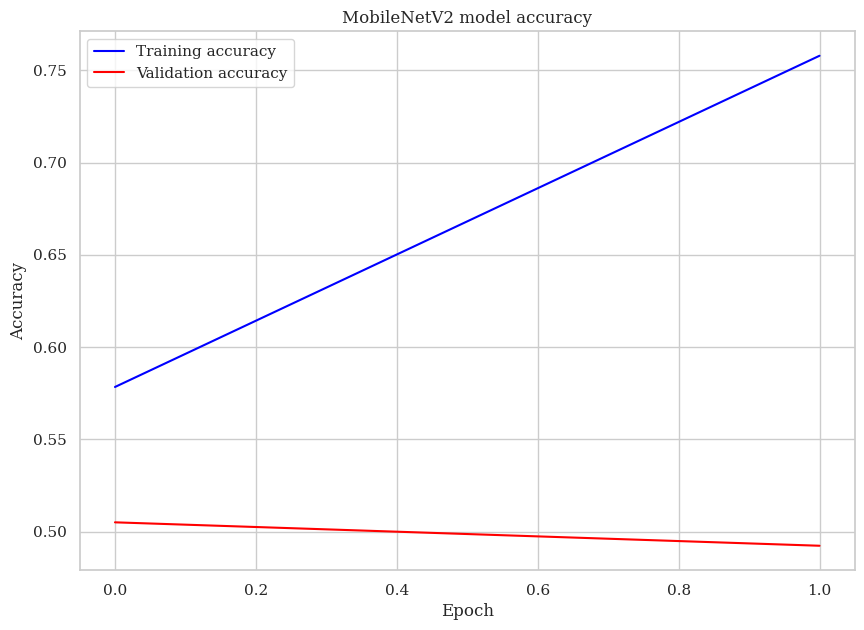

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot training and validation accuracy
plt.plot(MobileNetV2_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(MobileNetV2_history.history['val_accuracy'], label='Validation accuracy', color='red')

# Add title and labels
plt.title('MobileNetV2 model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the legend
plt.legend()

# Display the plot
plt.show()

### DenseNet121

In [ ]:
# Initialize Mirrored Strategy
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope
with strategy.scope():
  # Load the DenseNet121 base model
  DenseNet121_base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)
  )

  # Set the layer to non-train
  for layer in DenseNet121_base_model.layers:
    layer.trainable = False

  # Initialize the model
  DenseNet121_model = Sequential()
  DenseNet121_model.add(DenseNet121_base_model)

  # Add connected layers and output layer
  DenseNet121_model.add(GlobalAveragePooling2D())
  DenseNet121_model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  DenseNet121_model.add(Dropout(0.4))
  DenseNet121_model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
  DenseNet121_model.add(Dropout(0.2))
  DenseNet121_model.add(Dense(4, activation='softmax'))

  # Compile the model
  DenseNet121_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  # Fit the model
  DenseNet121_history = DenseNet121_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset,
    class_weight=class_weights,
    callbacks=[early_stopping],
  )

  # Save the model
  model_path = os.path.join("models", "densenet121_model.keras")
  DenseNet121_model.save(model_path)
  print(f"\nModel saved to {model_path}")

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.4574 - loss: 1.4787 - val_accuracy: 0.4721 - val_loss: 1.5285
Epoch 2/2
60/60 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.7350 - loss: 0.8261 - val_accuracy: 0.5203 - val_loss: 1.4690
Restoring model weights from the end of the best epoch: 2.

Model saved to models/densenet121_model.keras


In [ ]:
# Preview model summary
DenseNet121_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 9, 9, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,456,654 (28.44 MB)

 Trainable params: 139,716 (545.77 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

 Optimizer params: 279,434 (1.07 MB)

In [ ]:
# Validation accuracy
DenseNet121_val_loss, DenseNet121_val_accuracy = DenseNet121_model.evaluate(test_dataset, steps=len(test_dataset))
print('VALIDATION')
print(f'Accuracy: {DenseNet121_val_accuracy * 100:.2f}%')
print(f'Loss: {DenseNet121_val_loss:.2f}\n')

# Training accuracy
DenseNet121_train_loss, DenseNet121_train_accuracy = DenseNet121_model.evaluate(train_dataset, steps=len(train_dataset))
print('TRAINING')
print(f'Accuracy: {DenseNet121_train_accuracy * 100:.2f}%')
print(f'Loss: {DenseNet121_train_loss:.2f}')

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 732ms/step - accuracy: 0.4936 - loss: 1.4408
VALIDATION
Accuracy: 49.42%
Loss: 1.48

60/60 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8336 - loss: 0.5915
TRAINING
Accuracy: 83.84%
Loss: 0.59


#### Visualize the Model

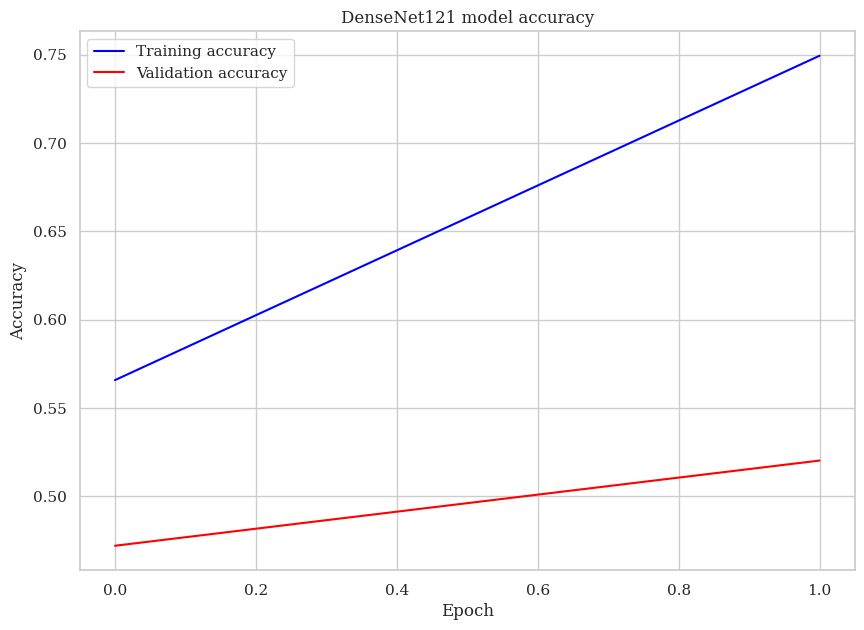

In [ ]:
# Set the figure size
plt.figure(figsize=(10, 7))

# Plot training and validation accuracy
plt.plot(DenseNet121_history.history['accuracy'], label='Training accuracy', color='blue')
plt.plot(DenseNet121_history.history['val_accuracy'], label='Validation accuracy', color='red')

# Add title and labels
plt.title('DenseNet121 model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Display the legend
plt.legend()

# Display the plot
plt.show()

## Model Performance Comparison

In [ ]:
models = {
  'VGG16': {
    'model': VGG16_model,
    'val_accuracy': VGG16_val_accuracy,
    'val_loss': VGG16_val_loss,
    'train_accuracy': VGG16_train_accuracy,
    'train_loss': VGG16_train_loss,
  },
  'MobileNetV2': {
    'model': MobileNetV2_model,
    'val_accuracy': MobileNetV2_val_accuracy,
    'val_loss': MobileNetV2_val_loss,
    'train_accuracy': MobileNetV2_train_accuracy,
    'train_loss': MobileNetV2_train_loss,
  },
  'DenseNet121': {
    'model': DenseNet121_model,
    'val_accuracy': DenseNet121_val_accuracy,
    'val_loss': DenseNet121_val_loss,
    'train_accuracy': DenseNet121_train_accuracy,
    'train_loss': DenseNet121_train_loss,
  }
}

# Extract the model names and performance metrics
model_names = list(models.keys())
val_accuracies = [models[model]['val_accuracy'] for model in model_names]
val_losses = [models[model]['val_loss'] for model in model_names]
train_accuracies = [models[model]['train_accuracy'] for model in model_names]
train_losses = [models[model]['train_loss'] for model in model_names]

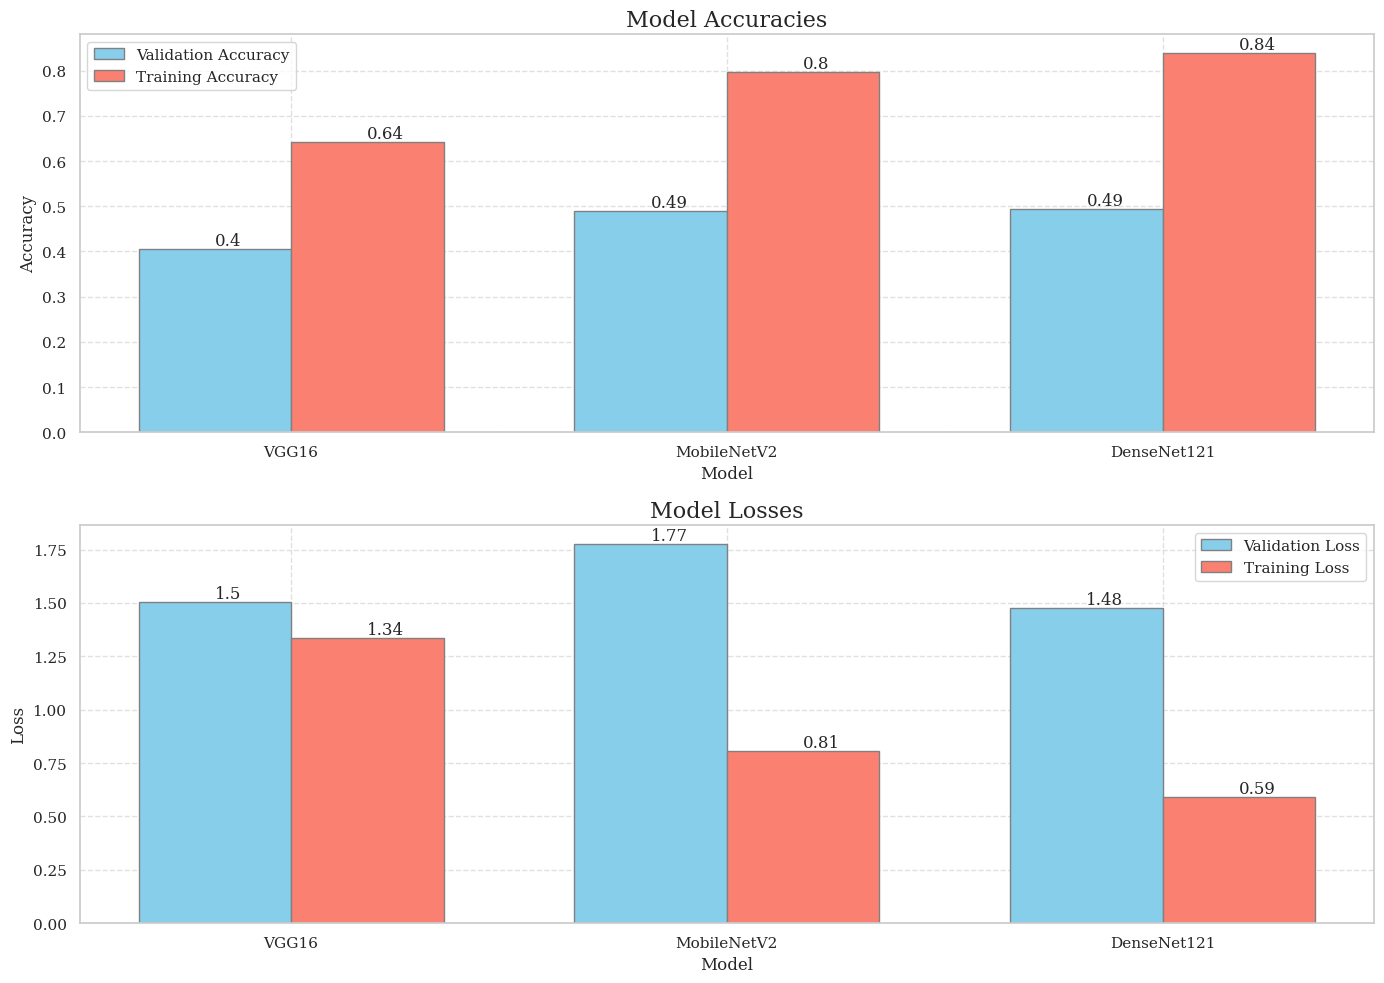

In [ ]:
# Set the figure size
plt.figure(figsize=(14, 10))

# Bar width
bar_width = 0.35

# Bar positions
r1 = np.arange(len(model_names))
r2 = [x + bar_width for x in r1]

# Plot all accuracies
plt.subplot(2, 1, 1)
bars1 = plt.bar(r1, val_accuracies, color='skyblue', width=bar_width, edgecolor='grey', label='Validation Accuracy')
bars2 = plt.bar(r2, train_accuracies, color='salmon', width=bar_width, edgecolor='grey', label='Training Accuracy')
plt.title('Model Accuracies', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks([r + bar_width/2 for r in range(len(model_names))], model_names)
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

# Add text annotations for accuracies
for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

# Plot all losses
plt.subplot(2, 1, 2)
bars3 = plt.bar(r1, val_losses, color='skyblue', width=bar_width, edgecolor='grey', label='Validation Loss')
bars4 = plt.bar(r2, train_losses, color='salmon', width=bar_width, edgecolor='grey', label='Training Loss')
plt.title('Model Losses', fontsize=16)
plt.xlabel('Model')
plt.ylabel('Loss')
plt.xticks([r + bar_width/2 for r in range(len(model_names))], model_names)
plt.legend()
plt.grid(linestyle='--', alpha=0.6)

# Add text annotations for losses
for bar in bars3:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')

for bar in bars4:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, round(yval, 2), va='bottom')



# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()